# In order to draw a graph of the sensitivity test results: 
1. use the 'read_results.m' in ezclimate folder to combine the test results and create a data file named 'sensitivity_reult_x.mat';
2. check the mat file and delete samples with NaN values
3. read the file and run the code below to generate the plot

In [35]:
import matplotlib.pyplot as plt
import scipy.io as sio
import pickle
import numpy as np

# read the file to variable data and import all the variables we concern

In [30]:
#load results stored in matlab
data = sio.loadmat('sensitivity_result_6.mat') #change the name of the file to read
p = np.array(-data['price_summary'])
m = np.array(data['mitigation_summary'])
iteration = np.array(data['iteration_summary'])
u = np.array(-data['utility_summary'])
u_node = np.array(-data['utility_node_summary'])
norm = np.array(data['final_norm_g_QN_summary'])
fcount = np.array(data['fcount_summary'])

# Import the treemodel

In [31]:
from tree import TreeModel

# GET_AVE_PRICE 
* takes the price results for each node and sample from the data
* returns the average price for all the periods of each sample

In [32]:
def get_ave_price(price,decision_times): #period average for each sample
    t = TreeModel(decision_times)
    nodes_index = []
    for i in range(t.num_periods): #get nodes for slicing
        nodes_index.append(t.get_nodes_in_period(i)) 
    period_price_ave = np.zeros((price.shape[1], t.num_periods))
    for i in range(price.shape[1]):  #calculate the period average for each sample
        for j in range(t.num_periods):
            period_price_ave[i][j] = np.average(price[:,i][nodes_index[j][0]:nodes_index[j][1]+1])
    return period_price_ave

# GET_90_QUANTILE
* takes the period average from get_ave_price
* returns 2 arrays list_min and list_max with 5% and 95% quantile values for the period averages

In [33]:
def get_90_quantile(period_price_ave): #5% and 95% percentiles for all the samples
    list0 = period_price_ave[:,0]
    list1 = period_price_ave[:,1]
    list2 = period_price_ave[:,2]
    list3 = period_price_ave[:,3]
    list4 = period_price_ave[:,4]
    list5 = period_price_ave[:,5]
    list_ = [list0,list1,list2,list3,list4,list5]
    fivepercent = int(len(list0)*0.05)
    for i in range(len(list_)):
        list_[i]=np.sort(list_[i])[fivepercent:-fivepercent] #take the 90% of the sorted results
    list_min = []
    list_max = []
    for i in list_:
        list_min.append(i[0])
        list_max.append(i[-1])   
    return list_min,list_max #take the lower and upper bounds for the test results

# Draw the graph: remember to change the name of the picture and the title!

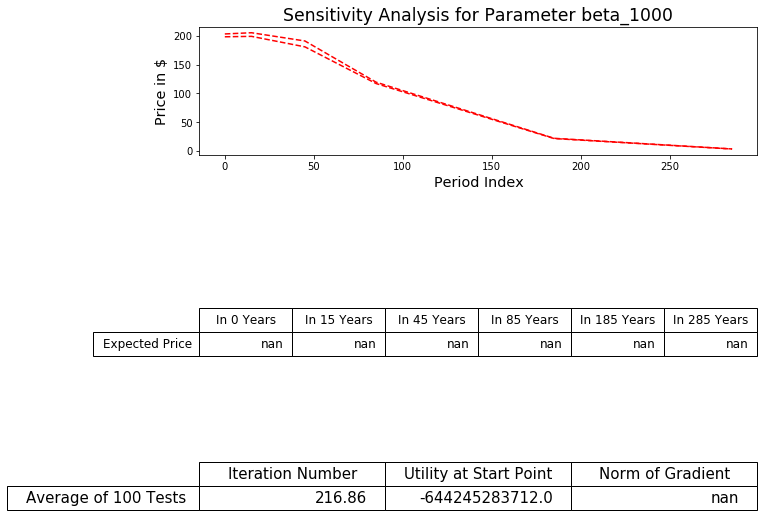

In [34]:
decision_times=[0, 15, 45, 85, 185, 285, 385]

#get the period average and 2 boundaries with get_ave_price and get_90_quantile
period_price_ave = get_ave_price(p, decision_times)
list_min,list_max = get_90_quantile(period_price_ave)

fig, (ax, tabay, tabax) = plt.subplots(nrows=3, figsize=(10,8))
#draw the subplot with the sample average and the 2 boundaries
ax.plot(decision_times[:-1],list_min, 'r--', 
        decision_times[:-1],list_max, 'r--',
        decision_times[:-1],np.average(period_price_ave,0),'b')
ax.set_title("Sensitivity Analysis for Parameter beta_1000", size ='xx-large')
ax.set_ylabel('Price in $', size = 'x-large')
ax.set_xlabel('Period Index', size = 'x-large')

#draw the table with the samples' period average
tabay.axis("off")
columns_price = ['In %d Years' %x for x in decision_times]
row_label_price = ['Expected Price']
cell_text_price = np.zeros([1,len(total_period_ave)])
cell_text_price[0] = np.average(period_price_ave)
the_table_price = tabay.table(cellText=cell_text_price,
                             rowLabels=row_label_price,
                             colLabels=columns_price)
the_table_price.set_fontsize(38)
the_table_price.scale(1,2)

#draw the table with the average of some parameters 
tabax.axis("off")
columns = ['Iteration Number','Utility at Start Point', 'Norm of Gradient'] #define the parameters
row_label = ['Average of %d Tests' %p.shape[1]] #define the label/content of the rows
rows = len(row_label) 
cell_text = np.zeros([1,len(columns)]) #define the content of the table
#append the cell_text if you want to display the information of all the inividual samples
#for row in range(len(norm)):
    #cell_text[row,:]=[iteration[row],u[row],norm[row]]
cell_text[0,:] = [np.average(iteration),np.average(u),np.average(norm)]

the_table = tabax.table(cellText=cell_text,
                  rowLabels=row_label,
                  #rowColours=colors,
                  colLabels=columns,
                       loc = 'bottom')#define the table
the_table.set_fontsize(34)
the_table.scale(1, 2)

#save the figure
fig.savefig('sensitivity_result_6_.eps',bbox_inches='tight')#change the name of the figure here
plt.show()

In [18]:
np.average(period_price_ave,0)

array([ 200.48204505,  210.37155   ,           nan,           nan,
                 nan,    3.80867777])